In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from comet_ml import Experiment

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
import optuna

from src.data.dataset import split_dataset
from src.features.features import advanced_features
from src.models.eval_plots import plot_roc_auc, plot_goal_rate, plot_cumulative_proportion, plot_calibration_curve

plt.rcParams["figure.figsize"] = (6, 6)
np.random.seed(0)

# Data Load

In [ ]:
season_plays_df = pd.read_csv("./data/processed/plays_2015-2020.csv", index_col=False)
train_df, test_df = split_dataset(season_plays_df)
y_train = np.where(train_df.event_type_id=="GOAL", 1, 0)
y_test = np.where(test_df.event_type_id=="GOAL", 1, 0)

# Preprocess

In [ ]:
pre_train_df = advanced_features(train_df)
pre_train_df = pre_train_df.drop(columns=["empty_net"])

In [ ]:
x_train = pre_train_df[["angle_from_net", "dist_from_net"]]

# XGBoost

In [ ]:
def evaluation_plots(model, X, y, model_name=None):
    y_proba = model.predict_proba(X)[:, 1]
    
    plot_roc_auc(y, y_proba, model_name=model_name)
    plot_goal_rate(y, y_proba, model_name=model_name)
    plot_cumulative_proportion(y, y_proba, model_name=model_name)
    plot_calibration_curve(y, y_proba, model_name=model_name)

## Base model

In [ ]:
base_params={
    "n_estimators": 100,
    "max_depth": 4,
    "learning_rate": 0.1,
}

def run_base_xgb(X, y, params, save_run=False):
    if save_run:
        experiment = Experiment(project_name="hockey-all-star-analytics", log_graph=True)
        experiment.log_dataset_hash(X)
        
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
        
    model = XGBClassifier(objective="binary:logistic", use_label_encoder=False, **params)
    
    model.fit(x_train, y_train,
              eval_set=[(x_val, y_val)],
              eval_metric=["logloss", "error", "auc"]
    )
    
    evaluation_plots(model, x_val, y_val, model_name="XGBoost Baseline")
    
    if save_run:
        model.save_model("./models/base_xgb.json")
        experiment.log_model("base_xgb", "./models/")
        experiment.end()
    return model

In [ ]:
base_model = run_base_xgb(x_train, y_train, base_params, save_run=False)

## Tuned XGBoost

In [ ]:
def objective(trial, x_df, y_df):
    hyperparams = {
        # structure
        "max_depth": trial.suggest_int("max_depth", 3, 8, step=1),
        # accuracy
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_categorical("n_estimators", [50]),
        # overfitting
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_child_weight": trial.suggest_float("min_gain_to_split", 0, 15),
    }
    
    kfold_cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for idx, (train_idx, test_idx) in enumerate(kfold_cv.split(x_df, y_df)):
        x_train, x_test = x_df.iloc[train_idx], x_df.iloc[test_idx]
        y_train, y_test = y_df.iloc[train_idx], y_df.iloc[test_idx]
        
        clf = XGBClassifier(use_label_encoder=False, **hyperparams)
        clf.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric=["logloss", "error", "auc"],
            verbose=False,
        )
        best_score = clf.evals_result()["validation_0"]["logloss"]
        cv_scores.append(best_score)
    
    return np.mean(cv_scores)


def run_tuned_xgb(x_df, y_df, save_run=False):
    if save_run:
        experiment = Experiment(project_name="hockey-all-star-analytics", log_code=True, log_graph=True)
        
    # optimize objective to tune XGBoost
    study = optuna.create_study(direction="minimize", study_name="tuned_xgboost")
    optimize = lambda trial: objective(trial, x_df, y_df)
    study.optimize(optimize, n_trials=20)
    
    # Train the model with the best parameters
    x_train, x_val, y_train, y_val = train_test_split(x_df.values, y_df.values, test_size=0.2, stratify=y_df.values)
    best_model = XGBClassifier(**study.best_params)
    best_model.fit(x_train, y_train,
                   eval_set=[(x_val, y_val)],
                   eval_metric=["logloss", "error", "auc"])
    

    evaluation_plots(best_model, x_val, y_val, model_name="XGBoost Tuned")
    
    feature_imp = pd.DataFrame(best_model.feature_importances_.T, index=x_df.columns, columns=["Permutation Feature Importance"])
    feature_imp.sort_values(by="Permutation Feature Importance", ascending=True).plot(kind="barh")
    
    if save_run:
        best_model.save_model("./models/best_xgb.json")
        experiment.log_model("best_xgb", "./models/")
        experiment.end()
    return best_model

In [ ]:
best_model = run_tuned_xgb(pre_train_df, pd.Series(y_train), save_run=True)

## Feature drop

In [ ]:
# best_model.get_params()
best_params = {
 'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.2990984444640177,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'lambda_l1': 45,
 'lambda_l2': 0,
 'min_gain_to_split': 14.173685506149932}

In [ ]:
pre_train_df["SHOT_grouped"] = pre_train_df.BLOCKED_SHOT + pre_train_df.MISSED_SHOT + pre_train_df.SHOT
subset_df = pre_train_df.drop(columns=["period_idx", "PENALTY", "x_coord", "y_coord", "BLOCKED_SHOT", "MISSED_SHOT", "SHOT", "PERIOD_START"])

In [ ]:
reduced_model = XGBClassifier(**best_params)

In [ ]:
experiment = Experiment(project_name="hockey-all-star-analytics", log_code=True, log_graph=True)

xx_df, y_df = subset_df, pd.Series(y_train)

x_train, x_val, yy_train, y_val = train_test_split(xx_df.values, y_df.values, test_size=0.2, stratify=y_df.values)
reduced_model = XGBClassifier(**best_params)
reduced_model.fit(x_train, yy_train,
                   eval_set=[(x_val, y_val)],
                   eval_metric=["logloss", "error", "auc"])
    

y_proba = reduced_model.predict_proba(x_val)[:, 1]

evaluation_plots(reduced_model, x_val, y_val, model_name="XGBoost reduced")

feature_imp = pd.DataFrame(reduced_model.feature_importances_.T, index=xx_df.columns, columns=["Permutation Feature Importance"])
feature_imp.sort_values(by="Permutation Feature Importance", ascending=True).plot(kind="barh")

reduced_model.save_model("./models/reduced_xgb.json")
experiment.log_model("reduced_xgb", "./models/")
experiment.end()

# Test set

In [ ]:
test_df_reg = test_df.loc[test_df.game_type=="R"].copy()
pre_test_df_reg = advanced_features(test_df_reg)
pre_test_df_reg["SHOT_grouped"] = pre_test_df_reg.BLOCKED_SHOT + pre_test_df_reg.MISSED_SHOT + pre_test_df_reg.SHOT
test_subset_df_reg = pre_test_df_reg.drop(columns=["period_idx", "PENALTY", "x_coord", "y_coord", "BLOCKED_SHOT", "MISSED_SHOT", "SHOT", "PERIOD_START", "empty_net"])

In [53]:
y_test_reg = np.where(test_df_reg.loc[test_df.game_type=="R"].copy().event_type_id=="GOAL", 1, 0)

In [71]:
test_df_poff = test_df.loc[test_df.game_type=="P"].copy()
pre_test_df_poff = advanced_features(test_df_poff)
pre_test_df_poff[['GOAL', 'OTHER', 'PENALTY', 'PERIOD_START']] = 0
pre_test_df_poff["SHOT_grouped"] = pre_test_df_poff.BLOCKED_SHOT + pre_test_df_poff.MISSED_SHOT + pre_test_df_poff.SHOT
test_subset_df_poff = pre_test_df_poff.drop(columns=["period_idx", "PENALTY", "x_coord", "y_coord", "BLOCKED_SHOT", "MISSED_SHOT", "SHOT", "PERIOD_START", "empty_net"])

C:\Users\TJ\miniconda3\envs\nice_play\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [76]:
y_test_poff = np.where(test_df_poff.loc[test_df_poff.game_type=="P"].copy().event_type_id=="GOAL", 1, 0)

In [60]:
x_test_reg = test_subset_df_reg.values
x_test_poff = test_subset_df_poff.values

In [57]:
y_proba_test_reg = reduced_model.predict_proba(x_test_reg)[:, 1]
#evaluation_plots(reduced_model, x_test_reg, y_test_reg, model_name="XGBoost reduced - Test")

In [80]:
y_proba_test_poff = reduced_model.predict_proba(x_test_poff)[:, 1]
#evaluation_plots(reduced_model, x_test_poff, y_test_poff, model_name="XGBoost reduced - Test")

In [85]:
np.save("./reports/milestone2/y_proba_test_reg.npy", y_proba_test_reg)
np.save("./reports/milestone2/y_proba_test_poff.npy", y_proba_test_poff)

# Finals plots

## preparing playoffs data

In [88]:
poff_results = pd.read_csv("./reports/milestone2/play_off_prediction_logistic.csv")
poff_results2 = pd.read_csv("./reports/milestone2/play_off_prediction.csv")

In [95]:
poff_results["pred_proba_best"] = poff_results2["pred_proba"]
poff_results["Prediction_best"] = poff_results2["Prediction"]
poff_results["pred_proba_xgboost_reduced"] = y_proba_test_poff

In [103]:
poff_results = poff_results.rename(columns=
    {"pred_proba_dist_only": "LogReg: dist",
     "pred_proba_angle_only": "LogReg: angle",
     "pred_proba_dist_angle": "LogReg: dist & angle",
     "pred_proba_best": "LGBM",
     "pred_proba_xgboost_reduced": "XGBoost reduced",
     }
)

poff_results = poff_results.drop(columns=['Prediction_dist_only', 'Prediction_angle_only',
       'Prediction_dist_angle', 'actual', 'Prediction_best'])

## preparing regular data

In [147]:
reg_results = pd.read_csv("./reports/milestone2/Regular_prediction_logistic.csv")
reg_results2 = pd.read_csv("./reports/milestone2/Regualar_prediction.csv")

In [148]:
reg_results["pred_proba_best"] = reg_results2["pred_proba"]
reg_results["Prediction_best"] = reg_results2["Prediction"]
reg_results["pred_proba_xgboost_reduced"] = y_proba_test_reg

In [151]:
reg_results = reg_results.rename(columns=
    {"pred_proba_dist_only": "LogReg: dist",
     "pred_proba_angle_only": "LogReg: angle",
     "pred_proba_dist_angle": "LogReg: dist & angle",
     "pred_proba_best": "LGBM",
     "pred_proba_xgboost_reduced": "XGBoost reduced",
     }
)

reg_results = reg_results.drop(columns=['Prediction_dist_only', 'Prediction_angle_only',
       'Prediction_dist_angle', 'actual', 'Prediction_best'])

## Plots

In [153]:
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

def random_baseline(y_test):
    baseline = np.zeros(y_test.shape)
    baseline[:int(len(baseline)/2)] = 1
    np.random.shuffle(baseline)
    return baseline

def all_roc_auc(y_true, y_results):
    fig, axs = plt.subplots(1, 1)
        
    for i in range(y_results.shape[1]):
        RocCurveDisplay.from_predictions(y_true, y_results.iloc[:, i], ax=axs, name=y_results.columns[i])
        
    baseline = random_baseline(y_true)
    baseline_kwargs = {
        "dashes": (1, 2, 1)
    }
    RocCurveDisplay.from_predictions(y_true, baseline, ax=axs, name="Random baseline", **baseline_kwargs)
    
    plt.title("Responder-Operator Curve (ROC) - Regular")
    plt.show()

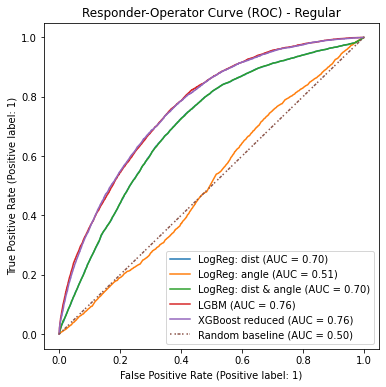

In [155]:
all_roc_auc(y_test_reg, reg_results)

In [156]:
def all_goal_rate(y_true, y_results):
    valid = pd.DataFrame()
    valid['true_labels'] = np.array(y_true)
    
    total_goal = np.sum(y_true)
    shot_prob_percentile = np.arange(0, 100, 5)


    for j in range(y_results.shape[1]):
        y_proba = y_results.iloc[:, j]
        percentile = [[np.percentile(y_proba, i), np.percentile(y_proba, i+5)] for i in range(0,100,5)]
        goal_rate = []
        cum=0
        for i in range(0, len(percentile)):
            goals = valid[ (y_proba<=percentile[i][1])&(y_proba>percentile[i][0]) & (valid['true_labels']==1)].shape[0]
            no_goals = valid[(y_proba<=percentile[i][1])&(y_proba>percentile[i][0]) & (valid['true_labels']==0)].shape[0]
            if goals==0:
                goal_rate.append(0)
            else:
                goal_rate.append((goals*100)/(goals+no_goals))
        
        plt.plot(shot_prob_percentile, goal_rate, label=y_results.columns[j])
       
    ##Plot of goal rate vs Shot probability percentile
        
    plt.xlim(100, 0)
    plt.ylim(0, 100)
    plt.title("Goal Rate - Regular")
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Goals / (Shots + Goals)', fontsize=14)
    plt.legend()
    plt.show()

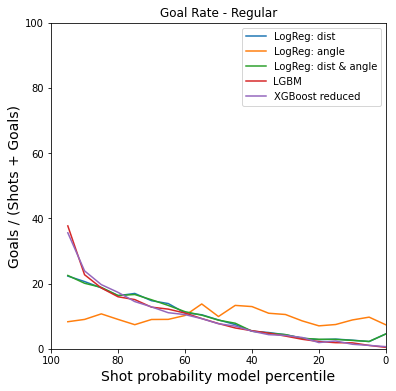

In [157]:
all_goal_rate(y_test_reg, reg_results)

In [158]:
def all_calibration_curve(y_true, y_results):
    fig, axs = plt.subplots(1, 1)

    for i in range(y_results.shape[1]):
         CalibrationDisplay.from_predictions(y_true, y_results.iloc[:, i], ax=axs, name=y_results.columns[i])
    
    plt.title("Calibration Curve - Regular")
    plt.show()

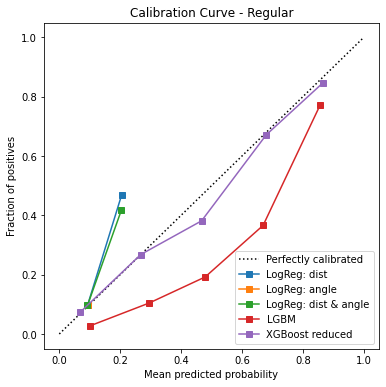

In [159]:
all_calibration_curve(y_test_reg, reg_results)

In [160]:
def all_cumulative_proportion(y_true, y_results):
    valid = pd.DataFrame()
    valid['true_labels'] = np.array(y_true)
    total_goal = np.sum(y_true)
    
    
    for j in range(y_results.shape[1]):
        y_proba = y_results.iloc[:, j]
        percentile = [[np.percentile(y_proba, i), np.percentile(y_proba, i+5)] for i in range(0,100,5)]
        cumulative = []
        for i in range(0, len(percentile)-1):
            goals = valid[(y_proba>=percentile[i][0]) & (y_true==1)].shape[0]
            cumulative.append(goals*100/total_goal)
        cumulative.append(0)
        
        shot_prob_percentile = np.arange(0, 100, 5)
        
        plt.plot(shot_prob_percentile, cumulative, label=y_results.columns[j])
    plt.xlim(100, 0)
    plt.ylim(0, 100)
    plt.title("Cumulative % of goals - Regular")
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.legend()
    plt.show()

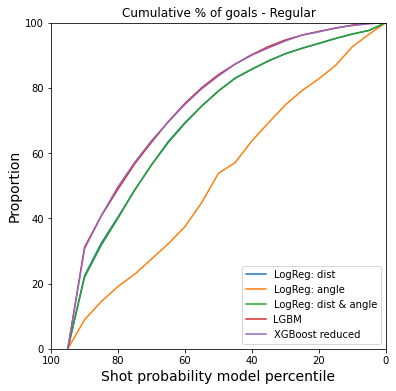

In [161]:
all_cumulative_proportion(y_test_reg, reg_results)